# 0. Install and Import Dependencies

In [ ]:
!pip list

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/LipNet/data.zip"

Archive:  /content/gdrive/MyDrive/LipNet/data.zip
   creating: data/
   creating: data/alignments/
   creating: data/alignments/s1/
  inflating: data/alignments/s1/bbaf2n.align  
  inflating: data/alignments/s1/bbaf3s.align  
  inflating: data/alignments/s1/bbaf4p.align  
  inflating: data/alignments/s1/bbaf5a.align  
  inflating: data/alignments/s1/bbal6n.align  
  inflating: data/alignments/s1/bbal7s.align  
  inflating: data/alignments/s1/bbal8p.align  
  inflating: data/alignments/s1/bbal9a.align  
  inflating: data/alignments/s1/bbas1s.align  
  inflating: data/alignments/s1/bbas2p.align  
  inflating: data/alignments/s1/bbas3a.align  
  inflating: data/alignments/s1/bbaszn.align  
  inflating: data/alignments/s1/bbaz4n.align  
  inflating: data/alignments/s1/bbaz5s.align  
  inflating: data/alignments/s1/bbaz6p.align  
  inflating: data/alignments/s1/bbaz7a.align  
  inflating: data/alignments/s1/bbbf6n.align  
  inflating: data/alignments/s1/bbbf7s.align  
  inflating: data/alig

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

In [ ]:
def load_video(path:str) -> List[float]: # path --> each video path

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #focuouse on lips part by cropping the image

        #Each video has 75 frame and each frame is now 236-190 = 46 width and 220-80 = 140 height
    cap.release()

    mean = tf.math.reduce_mean(frames) #calculating the overall mean
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) #calculating the overall sd
    return tf.cast((frames - mean), tf.float32) / std # standardizing each frame

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

In [ ]:
char_to_num(['a','b'])

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 2])>

In [ ]:
num_to_char([1,  2,  3, 4])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'a', b'b', b'c', b'd'], dtype=object)>

In [ ]:
"""
each alignments contains text like below

0 23750 sil

23750 29500 bin

29500 34000 blue

34000 35500 at

35500 41000 f

41000 47250 two

47250 53000 now

53000 74500 sil
"""

def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': # if the text is sil or silence then just ignore it
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
path = "/content/data/alignments/s1/bbaf2n.align"
load_alignments(path)

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

''

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

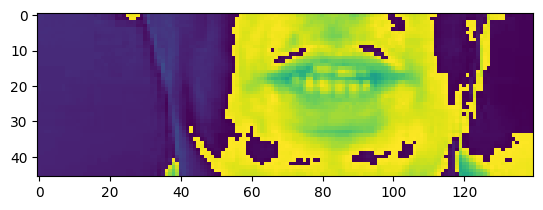

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result #it returns the video and the alignmetns in a list of length 2

In [ ]:
temp = mappable_function(test_path)

In [ ]:
len(temp)

2

# 2. Create Data Pipeline

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') #list down all the files which has file format .mpg or our videos
data = data.shuffle(500, reshuffle_each_iteration=False, seed=0) #shuffle each 500 videos and returns the data then shuffle next 500 videos and returns
data = data.map(mappable_function) #returns the video and the alignments
print(len(data))
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
#[75,None,None,None] means no padding for videos
#[40] means doing a padding for alignments with a length of 40
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(150)
test = data.skip(900)

1000


In [ ]:
frame,alignments = data.as_numpy_iterator().next()

In [ ]:
len(frame)

2

In [ ]:
alignments

array([[16, 12,  1,  3,  5, 39,  2, 12, 21,  5, 39, 23,  9, 20,  8, 39,
        16, 39, 14,  9, 14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39,  4,
        39, 26,  5, 18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
frame.shape

(2, 75, 46, 140, 1)

In [ ]:
len(test)

0

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next()

In [ ]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)#saving the whole video in gif format with a fps equal to 10

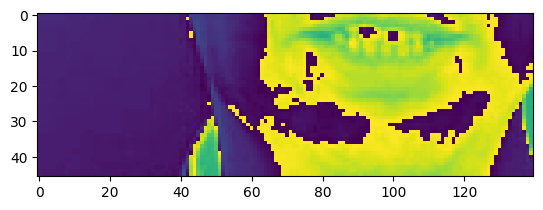

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video

#val[0] --> video
#val[1] --> alignments
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green with q zero please'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
5*17*75

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'                                                                     222222'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'                                                                     222222'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
#checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
checkpoint_callback = ModelCheckpoint(os.path.join('/content/gdrive/MyDrive/LipNet/model_weights_2','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
#example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/50
150/150 [==============================] - 171s 1s/step - loss: 99.8431 - lr: 1.0000e-04
Epoch 2/50
150/150 [==============================] - 150s 1s/step - loss: 77.7571 - lr: 1.0000e-04
Epoch 3/50
150/150 [==============================] - 151s 1s/step - loss: 75.1017 - lr: 1.0000e-04
Epoch 4/50
150/150 [==============================] - 150s 1000ms/step - loss: 72.7205 - lr: 1.0000e-04
Epoch 5/50
150/150 [==============================] - 150s 999ms/step - loss: 70.7609 - lr: 1.0000e-04
Epoch 6/50
150/150 [==============================] - 150s 1000ms/step - loss: 69.1993 - lr: 1.0000e-04
Epoch 7/50
150/150 [==============================] - 149s 993ms/step - loss: 68.8182 - lr: 1.0000e-04
Epoch 8/50
150/150 [==============================] - 150s 999ms/step - loss: 67.3262 - lr: 1.0000e-04
Epoch 9/50
150/150 [==============================] - 151s 1s/step - loss: 65.8895 - lr: 1.0000e-04
Epoch 10/50
150/150 [==============================] - 151s 1s/step - loss: 65.3306

In [ ]:
#model.save_weights('/content/gdrive/MyDrive/LipNet/Weights/my_checkpoint')

#Training2

In [ ]:
model.load_weights('/content/gdrive/MyDrive/LipNet/model_weights_1/checkpoint')

In [ ]:
model.fit(train, validation_data=test, epochs=100, initial_epoch=50, callbacks=[checkpoint_callback, schedule_callback])

Epoch 51/100
150/150 [==============================] - 170s 963ms/step - loss: 42.1343 - lr: 1.2246e-05
Epoch 52/100
150/150 [==============================] - 145s 965ms/step - loss: 41.2351 - lr: 1.1080e-05
Epoch 53/100
150/150 [==============================] - 145s 966ms/step - loss: 41.4514 - lr: 1.0026e-05
Epoch 54/100
150/150 [==============================] - 144s 959ms/step - loss: 41.2439 - lr: 9.0718e-06
Epoch 55/100
150/150 [==============================] - 145s 965ms/step - loss: 41.0137 - lr: 8.2085e-06
Epoch 56/100
150/150 [==============================] - 144s 961ms/step - loss: 40.7341 - lr: 7.4273e-06
Epoch 57/100
150/150 [==============================] - 146s 973ms/step - loss: 41.3394 - lr: 6.7205e-06
Epoch 58/100
150/150 [==============================] - 149s 992ms/step - loss: 40.3949 - lr: 6.0810e-06
Epoch 59/100
150/150 [==============================] - 145s 965ms/step - loss: 40.4102 - lr: 5.5023e-06
Epoch 60/100
150/150 [==============================] -

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
#model.load_weights('models/checkpoint')
path = os.path.join('/content/gdrive/MyDrive/LipNet/model_weights_1','checkpoint')


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
#yhat = model.predict(sample[0])
yhat = model.predict(val[0])

In [ ]:
#print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in val[1]]

[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in k zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green with o three soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
#print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'sia re it e an'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'la re t e plae'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]